<img src="../images/logos/arm_logo.png" width=500 alt="ARM Logo"></img>

# Snowfall Retrievals from SAIL X-Band Radar

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import glob
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pyart
import xarray as xr
from matplotlib.dates import DateFormatter

from metpy.plots import USCOUNTIES

import cartopy.crs as ccrs
import cartopy.feature as cfeature


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## Setup Helper Functions
We setup helper functions to calculate the snowfall retrieval, using following notation:

$Z = A*S ^ {B}$

Where:
- Z = Reflectivity in dBZ
- A = Coefficient applied to Z-S Relationship (not in the exponent)
- S = Liquid snowfall rate
- B = Coefficient applied to Z-S Relationship (in the exponent)

We also need to apply a snow water equivalent ratio (`swe`) to convert from liquid to snow (ex. 8 inches of snow --> 1 inch of rain would be 8.0).

This equation now becomes:

$Z = swe*A*S ^ {B}$

Solving for S, we get:

$S = swe * (\frac{z}{a})^{1/B}$

Where z is reflectivity in units of dB ($z =10^{Z/10}$)

In [2]:
def snow_rate(radar, swe_ratio, A, B, key="snow_z"):
    """
    Snow rate applied to a pyart.Radar object
    
    Takes a given Snow Water Equivilent ratio (swe_ratio), A and B value
    for the Z-S relationship and creates a radar field similar to DBZ
    showing the radar estimated snowfall rate in mm/hr. Then the given
    SWE_ratio, A and B are stored in the radar metadata for later 
    reference.

    """
    # Setting up for Z-S relationship:
    snow_z = radar.fields['corrected_reflectivity']['data'].copy()
    # Convert it from dB to linear units
    z_lin = 10.0**(radar.fields['corrected_reflectivity']['data']/10.)
    # Apply the Z-S relation.
    snow_z = swe_ratio * (z_lin/A)**(1./B)
    # Add the field back to the radar. Use reflectivity as a template
    radar.add_field_like('corrected_reflectivity', key,  snow_z,
                         replace_existing=True)
    # Update units and metadata
    radar.fields[key]['units'] = 'mm/h'
    radar.fields[key]['standard_name'] = 'snowfall_rate'
    radar.fields[key]['long_name'] = 'snowfall_rate_from_z'
    radar.fields[key]['valid_min'] = 0
    radar.fields[key]['valid_max'] = 500
    radar.fields[key]['swe_ratio'] = swe_ratio
    radar.fields[key]['A'] = A
    radar.fields[key]['B'] = B
    return radar

## List the Available Files
We will use files on the Oak Ridge Laboratory Computing Facility (ORLCF), within the shared SAIL directory `/gpfs/wolf/atm124/proj-shared/sail`.

These radar files have been merged from a single sweep in each file, to whole volume scans in each file.

In [3]:
file_list = sorted(glob.glob("/data/project/ARM_Summer_School_2024_Data/sail/radar/*))

In [4]:
file_list

['../data/sail/radar/gucxprecipradarcmacS2.c1.20220310.011126.nc']

## Read Data + Apply Snowfall Retrieval

In [5]:
radar = radar = pyart.io.read(file_list[0])

In [6]:
radar = snow_rate(radar, 8.5, 67, 1.28, key="snow_z_new")

/Users/jrobrien/micromamba/envs/arm-summer-school-2024-dev/lib/python3.11/site-packages/numpy/ma/core.py:6980: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [7]:
# Check to see if the snowfall retrieval was applied
list(radar.fields.keys())

['DBZ',
 'VEL',
 'WIDTH',
 'ZDR',
 'PHIDP',
 'RHOHV',
 'NCP',
 'DBZhv',
 'cbb_flag',
 'sounding_temperature',
 'height',
 'signal_to_noise_ratio',
 'velocity_texture',
 'gate_id',
 'simulated_velocity',
 'corrected_velocity',
 'unfolded_differential_phase',
 'corrected_differential_phase',
 'filtered_corrected_differential_phase',
 'corrected_specific_diff_phase',
 'filtered_corrected_specific_diff_phase',
 'corrected_differential_reflectivity',
 'corrected_reflectivity',
 'height_over_iso0',
 'specific_attenuation',
 'path_integrated_attenuation',
 'specific_differential_attenuation',
 'path_integrated_differential_attenuation',
 'rain_rate_A',
 'snow_rate_ws2012',
 'snow_rate_ws88diw',
 'snow_rate_m2009_1',
 'snow_rate_m2009_2',
 'snow_z_new']

/Users/jrobrien/micromamba/envs/arm-summer-school-2024-dev/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/jrobrien/micromamba/envs/arm-summer-school-2024-dev/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


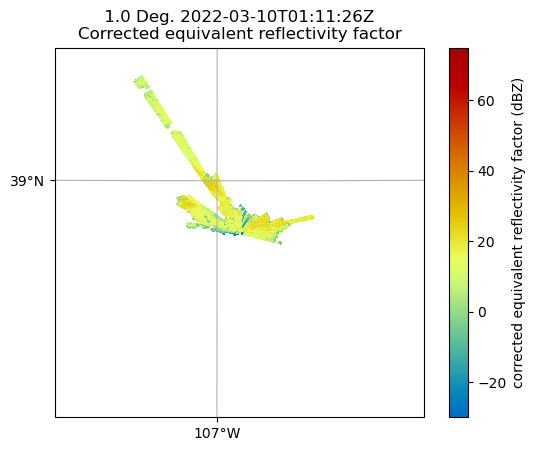

In [8]:
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi_map("corrected_reflectivity")

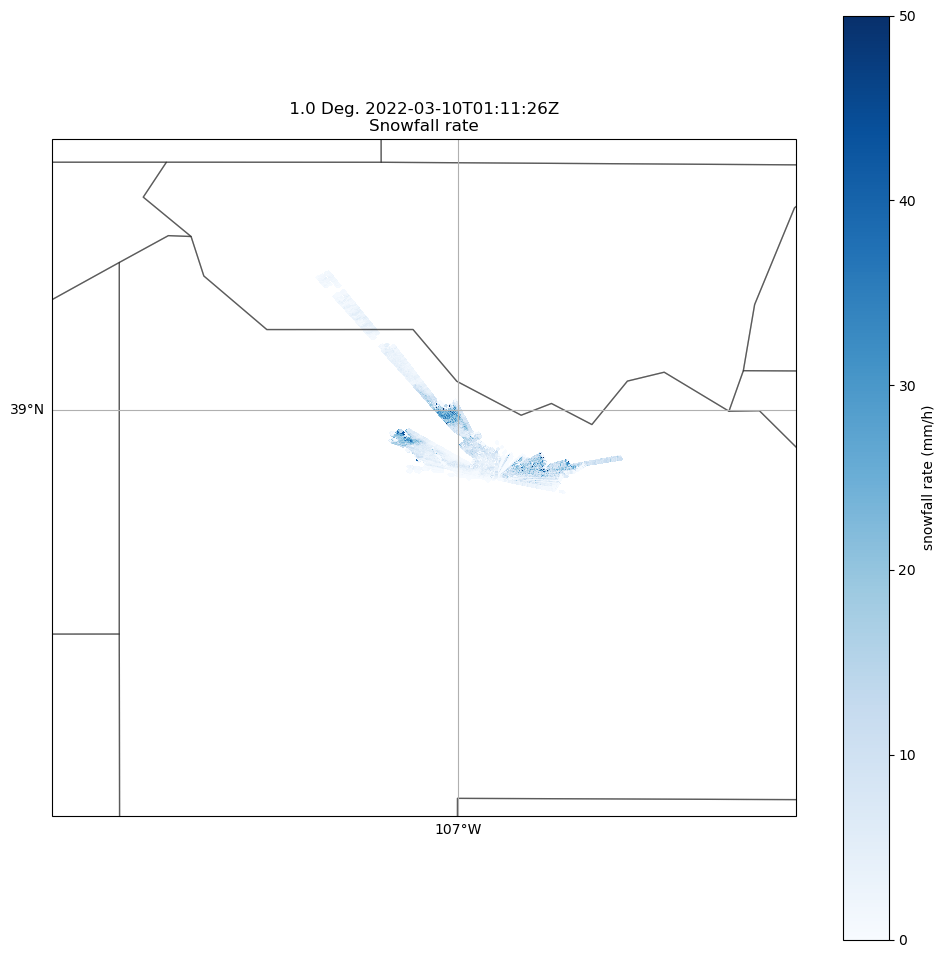

In [10]:
# Check to see if the snowfall retrieval was applied
# Now display the snowfall rates
#-------------------
# Plot the Radar PPI
#-------------------
bounds = [38.4, 39.4, -107.6, -106.5]

fig = plt.figure(figsize=[12, 12])
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
#ax1 = fig.add_subplot(111)

ax1.add_feature(cfeature.STATES, linewidth=3)
ax1.add_feature(USCOUNTIES, alpha=0.4)

# Create the Radar Display Object
display = pyart.graph.RadarMapDisplay(radar)

# Plot the reflectivty
# Note - I did not add the sweep parameter since there is only one sweep per file!
display.plot_ppi_map('snow_z_new', 
                     ax=ax1,
                     vmin=0,
                     vmax=50,
                     min_lat=bounds[0],
                     max_lat=bounds[1],
                     min_lon=bounds[2],
                     max_lon=bounds[3],
                     embellish=False,
                     norm=None,
                     cmap='Blues')